reference：https://github.com/aptx4869yuyang2017/Home_Credit_Default_Risk_my_notebook/blob/master/gplearn_feature.ipynb

gplearn这个库提供了解决的思路：

- 随机化生成大量特征组合方式，解决了没有先验知识，手工生成特征费时费力的问题
- 通过遗传算法进行特征组合的迭代，而且这种迭代是有监督的迭代，存留的特征和label相关性是也来越高的，大量低相关特征组合会在迭代中被淘汰掉，用决策树算法做个类比的话，我们自己组合特征然后筛选，好比是后剪枝过程，遗传算法进行的则是预剪枝的方式。

- 特征和label的相关性
- 特征之间的共线性
- 特征在模型中的重要程度
- 特征对模型性能的提升

In [1]:
import numpy as np
import pandas as pd
np.random.seed(7)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from gplearn.genetic import SymbolicTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

In [2]:
## 数据
def data_prepare():
    boston = load_boston()
    boston_feature = pd.DataFrame(boston.data, columns=boston.feature_names)
    boston_label = pd.Series(boston.target).to_frame("TARGET")

    boston = pd.concat([boston_label, boston_feature], axis=1)
    
    return boston

data = data_prepare()
print(data.shape)

(506, 14)


In [3]:
data

,TARGET,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,21.6,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,34.7,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,33.4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,36.2,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,22.4,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,20.6,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,23.9,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,22.0,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


2 15


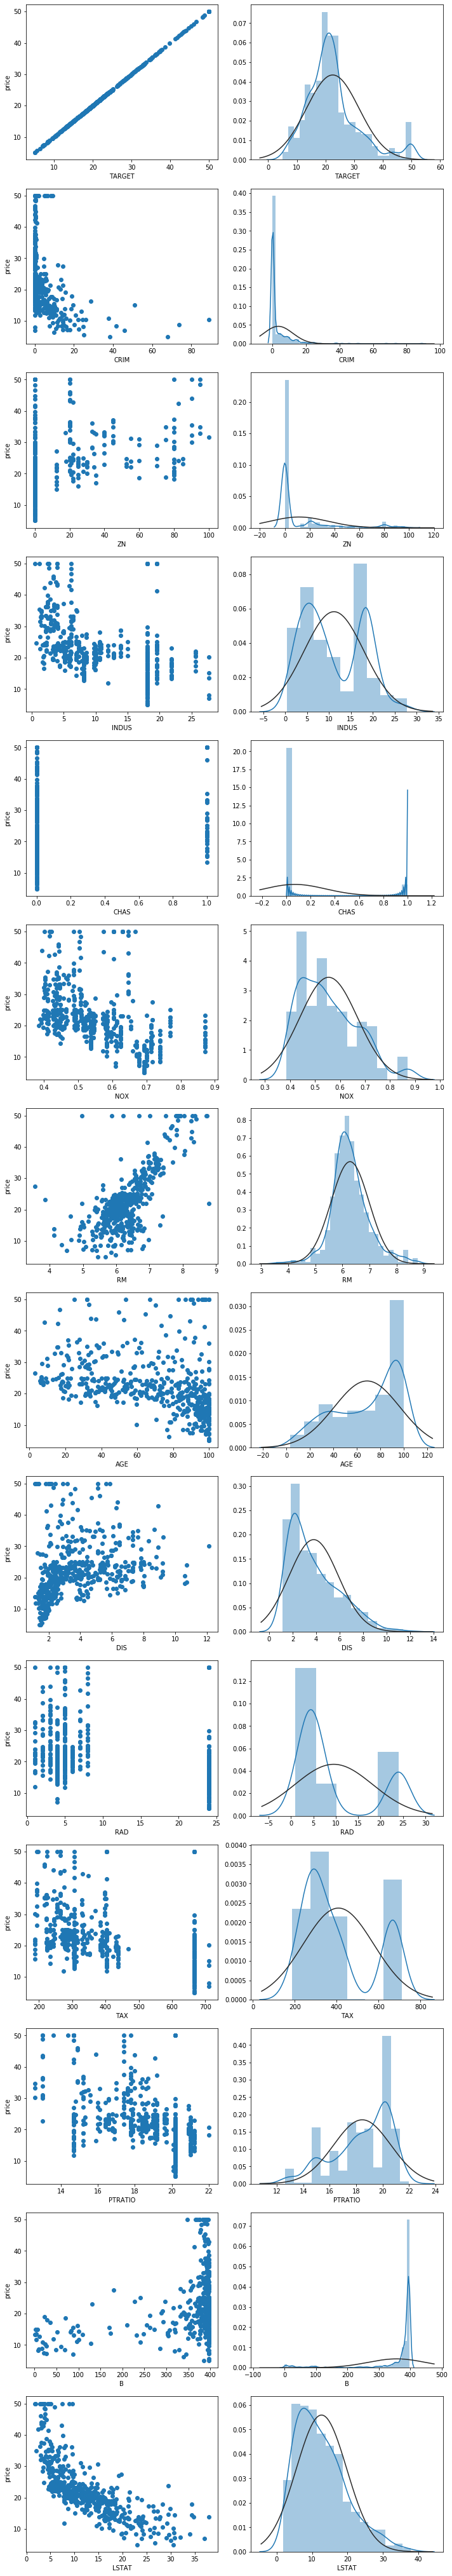

In [4]:
# 查看现有特征分布

def plot_dist(df, feature, pic_name='dist_plot.png'):
    fcols = 2
    frows = len(feature) + 1
    print(fcols, frows)
    plt.figure(figsize=(5*fcols, 4*frows))

    i = 0
    for col in feature:
        
        i += 1
        ax = plt.subplot(frows, fcols, i)

        plt.scatter(df[col], df['TARGET'])

        plt.xlabel(col)
        plt.ylabel('price')

        i += 1
        ax = plt.subplot(frows, fcols, i)
        sns.distplot(df[col].dropna(), fit=stats.norm)
        plt.xlabel(col)

    plt.tight_layout()
    
plot_dist(data, data.columns)

In [5]:
# 使用log1p变换将特征基本拉到一个尺度进行建模
for col in data.columns.drop('TARGET'):
    data[col] = np.log1p(data[col])

2 15


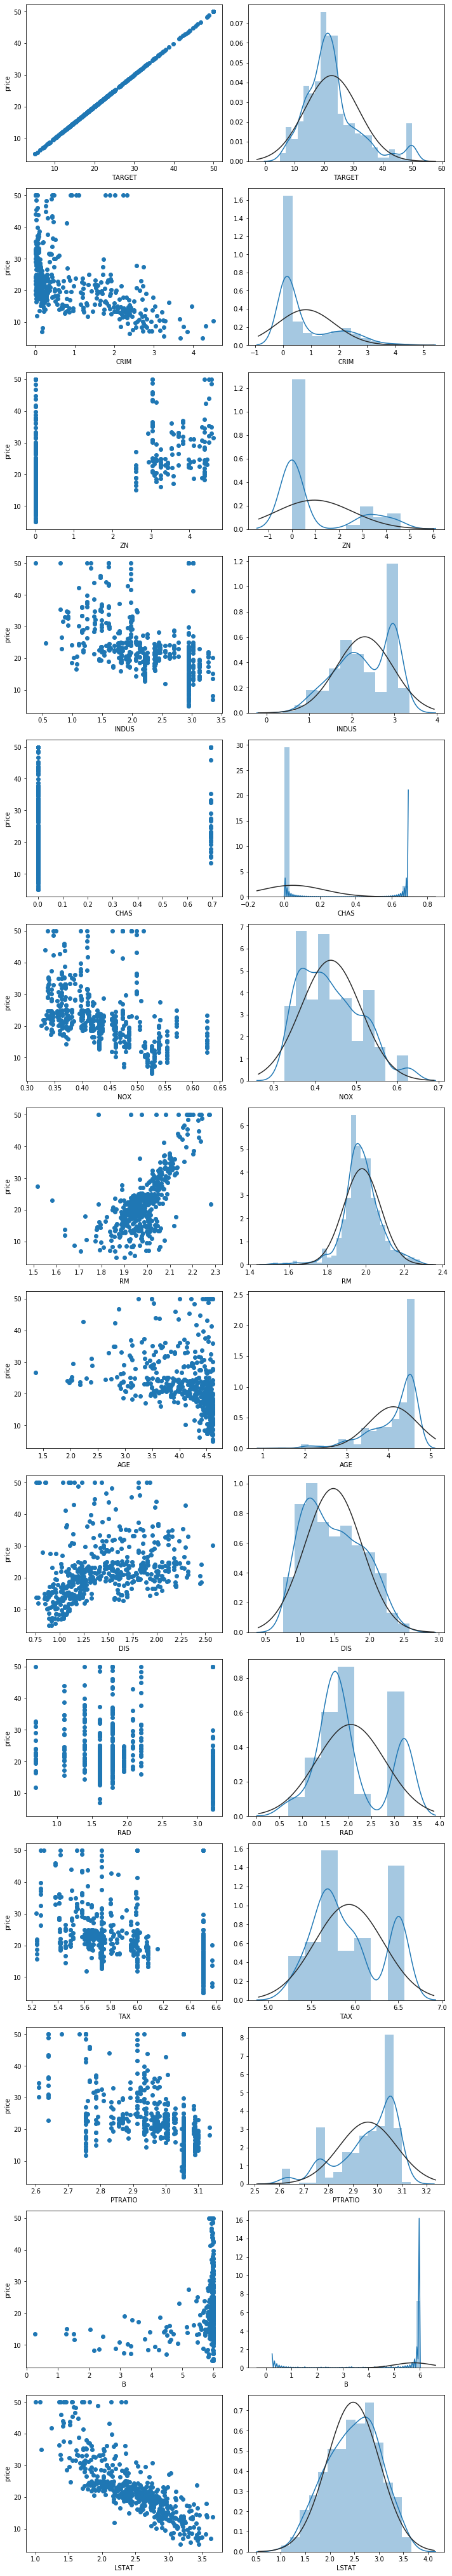

In [6]:
# 观察新的特征的分布
plot_dist(data, data.columns)

In [7]:
corr = data.corr('spearman')
corr

,TARGET,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
TARGET,1.000000,-0.558891,0.438179,-0.578255,0.140612,-0.562609,0.633576,-0.547562,0.445857,-0.346776,-0.562411,-0.555905,0.185664,-0.852914
CRIM,-0.558891,1.000000,-0.571660,0.735524,0.041537,0.821465,-0.309116,0.704140,-0.744986,0.727807,0.729045,0.465283,-0.360555,0.634760
ZN,0.438179,-0.571660,1.000000,-0.642811,-0.041937,-0.634828,0.361074,-0.544423,0.614627,-0.278767,-0.371394,-0.448475,0.163135,-0.490074
INDUS,-0.578255,0.735524,-0.642811,1.000000,0.089841,0.791189,-0.415301,0.679487,-0.757080,0.455507,0.664361,0.433710,-0.285840,0.638747
CHAS,0.140612,0.041537,-0.041937,0.089841,1.000000,0.068426,0.058813,0.067792,-0.080248,0.024579,-0.044486,-0.136065,-0.039810,-0.050575
NOX,-0.562609,0.821465,-0.634828,0.791189,0.068426,1.000000,-0.310344,0.795153,-0.880015,0.586429,0.649527,0.391309,-0.296662,0.636828
RM,0.633576,-0.309116,0.361074,-0.415301,0.058813,-0.310344,1.000000,-0.278082,0.263168,-0.107492,-0.271898,-0.312923,0.053660,-0.640832
AGE,-0.547562,0.704140,-0.544423,0.679487,0.067792,0.795153,-0.278082,1.000000,-0.801610,0.417983,0.526366,0.355384,-0.228022,0.657071
DIS,0.445857,-0.744986,0.614627,-0.757080,-0.080248,-0.880015,0.263168,-0.801610,1.000000,-0.495806,-0.574336,-0.322041,0.249595,-0.564262
RAD,-0.346776,0.727807,-0.278767,0.455507,0.024579,0.586429,-0.107492,0.417983,-0.495806,1.000000,0.704876,0.318330,-0.282533,0.394322


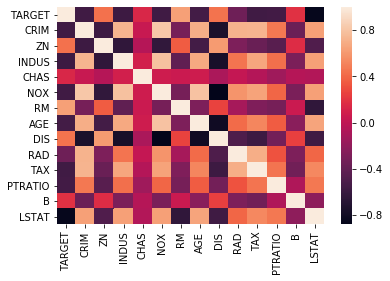

In [8]:
sns.heatmap(corr)

In [9]:
threshold = 0.85
correlated_pairs= {}
for col in corr:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(corr.index[abs(corr[col]) > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [10]:
correlated_pairs

{'TARGET': ['LSTAT'],
 'CRIM': [],
 'ZN': [],
 'INDUS': [],
 'CHAS': [],
 'NOX': ['DIS'],
 'RM': [],
 'AGE': [],
 'DIS': ['NOX'],
 'RAD': [],
 'TAX': [],
 'PTRATIO': [],
 'B': [],
 'LSTAT': ['TARGET']}

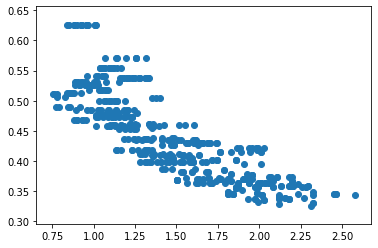

In [11]:
plt.scatter(data['DIS'], data['NOX'])

特征LSTAT 和 target 相关性较高， DIS 和 NOX 两个特征相关性较高,可视化展示一下

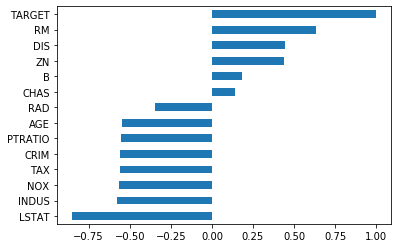

In [12]:
corr['TARGET'].sort_values().plot.barh()

## 原始特征建模

In [13]:
features = data.columns.drop('TARGET') 
x_train, x_test, y_train, y_test = train_test_split(data[features], data['TARGET'].to_frame(),
                                                        test_size=0.3, shuffle=True)

In [14]:
def Preds(x, y, x_test, y_test, alpha, n_splits=4, random_state=23, verbose=0):
    feature_importance = pd.DataFrame(columns=['feature', 'importance', 'fold'])

    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof_preds, sub_preds = np.zeros(x.shape[0]), np.zeros(x_test.shape[0])

    oof_train = np.zeros(x.shape[0])

    if verbose > 0:
        print(x.shape, x_test.shape)

    train_scores = []
    valid_scores = []
    test_scores = []


    for n_fold, (trn_idx, val_idx) in enumerate(folds.split(x, y)):
        trn_x, trn_y = x.iloc[trn_idx, :], y.iloc[trn_idx, :]
        val_x, val_y = x.iloc[val_idx, :], y.iloc[val_idx, :]

        # print(type(trn_x.values), type(trn_y.values), type(val_x.values), type(val_y.values))
        #
        # print(trn_x.shape, trn_y.shape)
        # print(val_x.shape, val_y.values.ravel().shape)

        model = Ridge(alpha=alpha) 
        model.fit(trn_x.values, trn_y.values.ravel())

        trn_preds = model.predict(trn_x)
        val_preds = model.predict(val_x)
        test_preds = model.predict(x_test)

        oof_preds[val_idx] = val_preds
        sub_preds += test_preds/folds.n_splits

        train_score = mean_squared_error(trn_y, trn_preds)
        val_score = mean_squared_error(val_y, val_preds)
        test_score = mean_squared_error(y_test, test_preds)

        train_scores.append(train_score)
        valid_scores.append(val_score)
        test_scores.append(test_score)

        feature_importance = feature_importance.append(pd.DataFrame({
            'importance': model.coef_,
            'fold': [n_fold + 1] * x.shape[1],
            'feature': x.columns.tolist()
        }))

  
    feature_importance['importance'] = feature_importance['importance'].astype(float)

    fi = feature_importance.groupby(['feature']).agg(['mean'])['importance'].sort_values(by=['mean'], ascending=False)

    fold_names = list(range(folds.n_splits))
    fold_names.append('overall')

    valid_mse = mean_squared_error(y, oof_preds)

    valid_scores.append(valid_mse)
    train_scores.append(np.mean(train_scores))
    test_scores.append(np.mean(test_scores))

    # 构建记录分数的 Dataframe
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores,
                            'test': test_scores})

    oof_preds = pd.Series(oof_preds.flatten(), index=x.index).rename('TARGET')
    sub_preds = pd.Series(sub_preds.flatten(), index=x_test.index).rename('TARGET')

    return metrics, fi

In [15]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
for alpha in alphas:
    metrics, fi = Preds(x_train, y_train, x_test, y_test, alpha)
    print('\n{}'.format(alpha))
    print(metrics)

# 验证集上 0.01最优
metrics, fi = Preds(x_train, y_train, x_test, y_test, 0.01)


0.001
      fold      train      valid       test
0        0  18.864104  15.607442  20.610661
1        1  15.814994  24.232774  19.991547
2        2  17.177757  20.277304  18.726520
3        3  17.675552  18.206061  18.274392
4  overall  17.383102  19.582812  19.400780

0.005
      fold      train      valid       test
0        0  18.864486  15.582767  20.586877
1        1  15.815235  24.242050  19.978781
2        2  17.178118  20.277061  18.715476
3        3  17.675883  18.213485  18.264841
4  overall  17.383431  19.580725  19.386494

0.01
      fold      train      valid       test
0        0  18.865634  15.552992  20.557963
1        1  15.815957  24.253405  19.963094
2        2  17.179194  20.277742  18.702504
3        3  17.676872  18.223406  18.253631
4  overall  17.384414  19.578730  19.369298

0.05
      fold      train      valid       test
0        0  18.894710  15.349556  20.352260
1        1  15.834079  24.334397  19.845353
2        2  17.205614  20.312184  18.623052
3     

In [16]:
fi

,mean
feature,
RM,23.468831
CHAS,3.676937
RAD,3.002676
B,1.123515
AGE,0.345524
ZN,0.062442
INDUS,-1.045623
CRIM,-1.116932
TAX,-3.614236


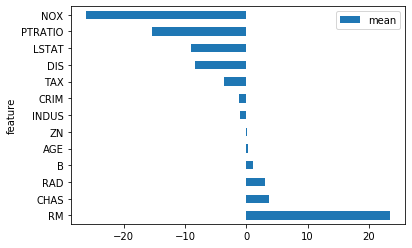

In [17]:
fi.plot.barh()

## 构造新特征 1

In [18]:
function_set = ['add', 'sub', 'mul', 'div', 'log', 'sqrt', 'abs', 'neg', 'max', 'min']

gp1 = SymbolicTransformer(generations=10, population_size=1000,
                         hall_of_fame=100, n_components=10,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=1,
                         random_state=0, n_jobs=3)

train_idx = x_train.index
test_idx = x_test.index

gp1.fit(x_train, y_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    13.25         0.352558        4         0.839964          0.86314     12.42s
   1     7.74          0.65142        4         0.854811         0.613415      9.26s
   2     5.09         0.745207        6         0.865075         0.878227      9.00s
   3     7.03         0.751879        7         0.876343         0.795134      8.13s
   4     7.16          0.75918       10         0.882833         0.707373      7.06s
   5     7.81         0.759858       10         0.890308         0.596763      5.24s
   6     7.34         0.744429        8         0.893363         0.714507      3.67s
   7     7.39         0.755904        8         0.896596         0.696237      2.47s
   8     6.92         0.749452        8         0.893614         0.730238  

SymbolicTransformer(const_range=(-1.0, 1.0), feature_names=None,
                    function_set=['add', 'sub', 'mul', 'div', 'log', 'sqrt',
                                  'abs', 'neg', 'max', 'min'],
                    generations=10, hall_of_fame=100, init_depth=(2, 6),
                    init_method='half and half', low_memory=False,
                    max_samples=0.9, metric='pearson', n_components=10,
                    n_jobs=3, p_crossover=0.9, p_hoist_mutation=0.01,
                    p_point_mutation=0.01, p_point_replace=0.05,
                    p_subtree_mutation=0.01, parsimony_coefficient=0.0005,
                    population_size=1000, random_state=0, stopping_criteria=1.0,
                    tournament_size=20, verbose=1, warm_start=False)

In [19]:
print(gp1)

[div(min(X5, X5), add(X10, X12)),
 sub(-0.988, div(min(X5, X5), log(div(X5, add(X10, X12))))),
 div(X5, add(X10, add(X10, X12))),
 div(div(X5, add(X10, X12)), add(X10, X12)),
 div(log(log(div(X5, add(X10, X12)))), add(X10, X12)),
 div(X5, log(sqrt(add(X10, X12)))),
 div(sqrt(div(X5, add(X10, X12))), add(X10, X12)),
 div(X5, add(add(X10, X12), X12)),
 log(div(X5, add(X10, X12))),
 div(div(X5, add(X10, X12)), log(div(sub(div(X5, add(X10, X12)), min(X5, X5)), add(X10, X12))))]


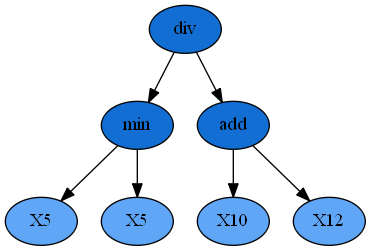

In [26]:
import os
 
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin'
from IPython.display import Image
import pydotplus
graph = gp1._best_programs[0].export_graphviz()
graph = pydotplus.graphviz.graph_from_dot_data(graph)
Image(graph.create_png())

In [27]:
gp_train_feature = gp1.transform(x_train)
gp_test_feature = gp1.transform(x_test)

new_feature_name = [str(i)+'V' for i in range(1, 11)]
train_new_feature = pd.DataFrame(gp_train_feature, columns=new_feature_name, index=train_idx)
test_new_feature = pd.DataFrame(gp_test_feature, columns=new_feature_name, index=test_idx)

In [28]:
# 将原始特征和新特征合并
x_train_0 = pd.concat([x_train, train_new_feature], axis=1)
x_test_0 = pd.concat([x_test, test_new_feature], axis=1)

new_x_data = pd.concat([x_train_0, x_test_0], axis=0)
new_data = pd.concat([data['TARGET'], new_x_data], axis=1)

In [29]:
new_data.columns

Index(['TARGET', 'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
       'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', '1V', '2V', '3V', '4V', '5V',
       '6V', '7V', '8V', '9V', '10V'],
      dtype='object')

## 新特征1的分布

2 11


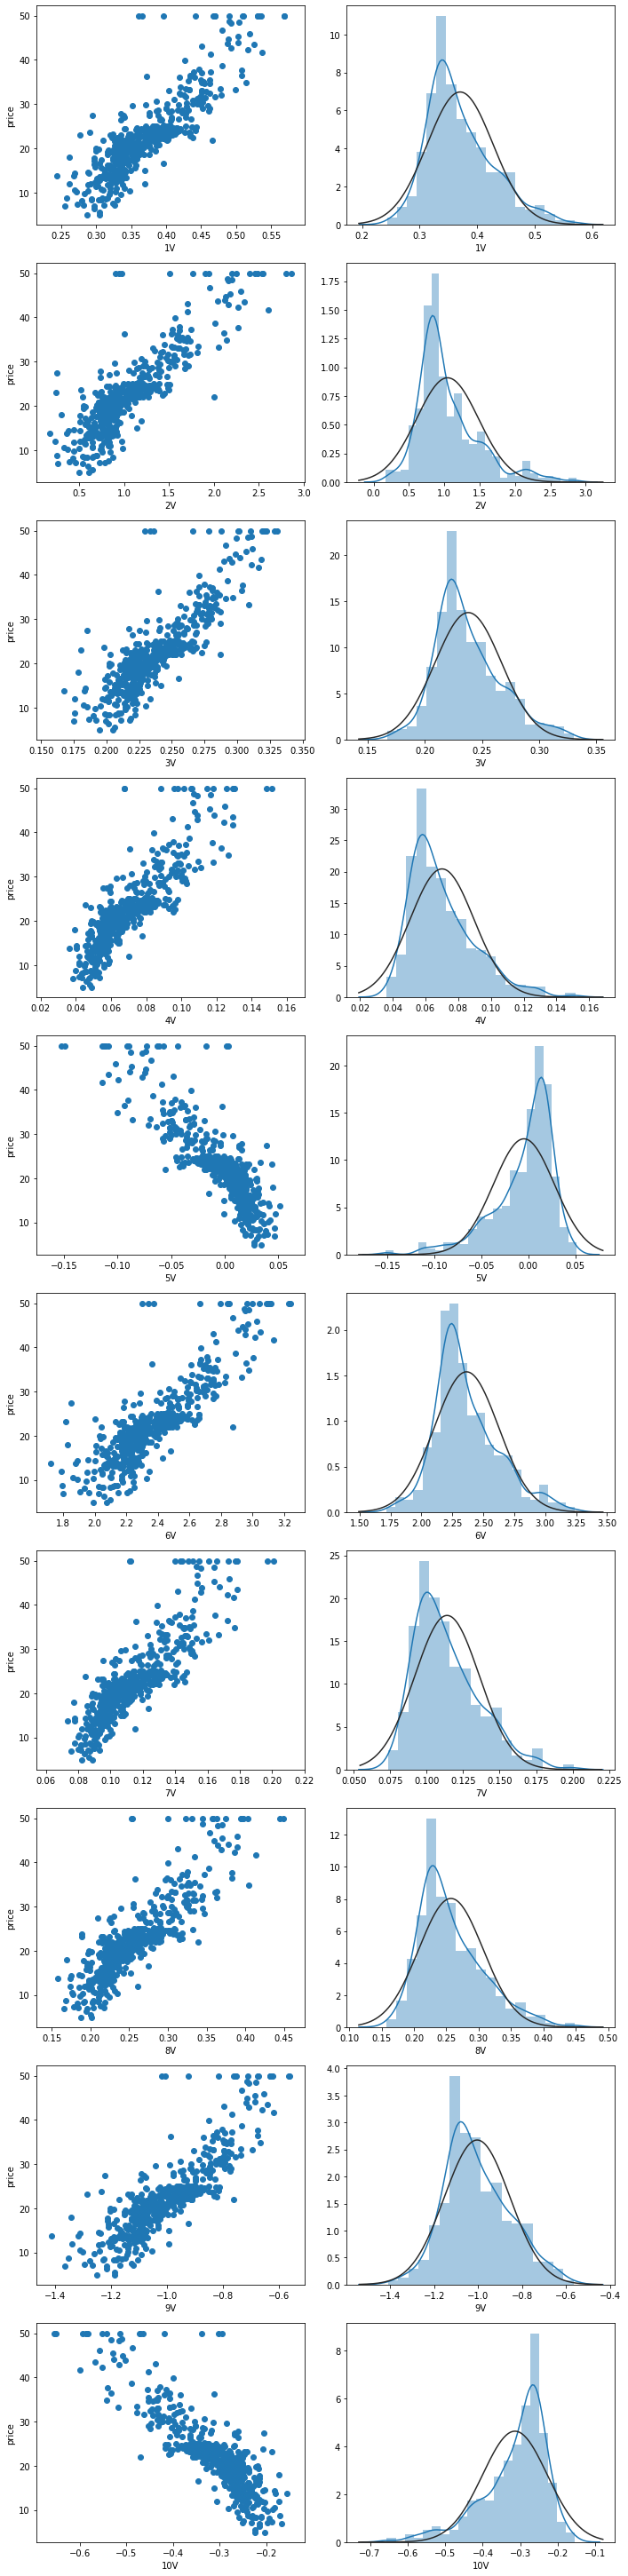

In [30]:
plot_dist(new_data, new_feature_name)

In [31]:
new_corr = new_data.corr('spearman')

In [32]:
new_corr

,TARGET,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,1V,2V,3V,4V,5V,6V,7V,8V,9V,10V
TARGET,1.000000,-0.558891,0.438179,-0.578255,0.140612,-0.562609,0.633576,-0.547562,0.445857,-0.346776,-0.562411,-0.555905,0.185664,-0.852914,0.860760,0.831370,0.851298,0.870853,-0.856905,0.841034,0.872339,0.860702,0.860760,-0.858390
CRIM,-0.558891,1.000000,-0.571660,0.735524,0.041537,0.821465,-0.309116,0.704140,-0.744986,0.727807,0.729045,0.465283,-0.360555,0.634760,-0.610137,-0.561100,-0.597124,-0.632636,0.606476,-0.575708,-0.638501,-0.615785,-0.610137,0.605036
ZN,0.438179,-0.571660,1.000000,-0.642811,-0.041937,-0.634828,0.361074,-0.544423,0.614627,-0.278767,-0.371394,-0.448475,0.163135,-0.490074,0.515195,0.496038,0.519972,0.522433,-0.514665,0.502560,0.524323,0.506824,0.515195,-0.513073
INDUS,-0.578255,0.735524,-0.642811,1.000000,0.089841,0.791189,-0.415301,0.679487,-0.757080,0.455507,0.664361,0.433710,-0.285840,0.638747,-0.636452,-0.606435,-0.624598,-0.647182,0.634210,-0.617046,-0.649468,-0.639397,-0.636452,0.633855
CHAS,0.140612,0.041537,-0.041937,0.089841,1.000000,0.068426,0.058813,0.067792,-0.080248,0.024579,-0.044486,-0.136065,-0.039810,-0.050575,0.068970,0.063478,0.078355,0.070837,-0.066838,0.063532,0.070837,0.063105,0.068970,-0.068277
NOX,-0.562609,0.821465,-0.634828,0.791189,0.068426,1.000000,-0.310344,0.795153,-0.880015,0.586429,0.649527,0.391309,-0.296662,0.636828,-0.598750,-0.557065,-0.575474,-0.617590,0.596815,-0.570430,-0.622209,-0.610196,-0.598750,0.594549
RM,0.633576,-0.309116,0.361074,-0.415301,0.058813,-0.310344,1.000000,-0.278082,0.263168,-0.107492,-0.271898,-0.312923,0.053660,-0.640832,0.781473,0.864433,0.806493,0.720509,-0.788822,0.843991,0.696073,0.761261,0.781473,-0.792906
AGE,-0.547562,0.704140,-0.544423,0.679487,0.067792,0.795153,-0.278082,1.000000,-0.801610,0.417983,0.526366,0.355384,-0.228022,0.657071,-0.600422,-0.548232,-0.568915,-0.625786,0.597325,-0.564432,-0.632834,-0.617647,-0.600422,0.594566
DIS,0.445857,-0.744986,0.614627,-0.757080,-0.080248,-0.880015,0.263168,-0.801610,1.000000,-0.495806,-0.574336,-0.322041,0.249595,-0.564262,0.531250,0.490094,0.509066,0.548261,-0.529366,0.502774,0.551673,0.542098,0.531250,-0.527314
RAD,-0.346776,0.727807,-0.278767,0.455507,0.024579,0.586429,-0.107492,0.417983,-0.495806,1.000000,0.704876,0.318330,-0.282533,0.394322,-0.364927,-0.315621,-0.354298,-0.390779,0.360011,-0.329203,-0.397841,-0.369379,-0.364927,0.358563


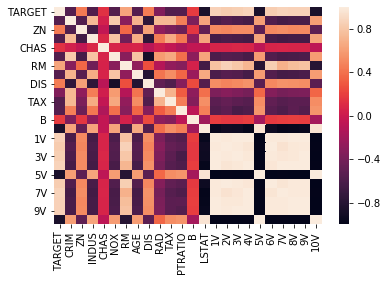

In [33]:
sns.heatmap(new_corr)

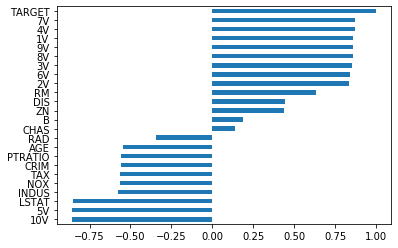

In [34]:
new_corr['TARGET'].sort_values().plot.barh()

新特征与label的相关性都很高

## 特征之间的相关性

In [35]:
new_features_corr = new_data[new_feature_name].corr('spearman')
new_features_corr

,1V,2V,3V,4V,5V,6V,7V,8V,9V,10V
1V,1.000000,0.985936,0.992656,0.993647,-0.999698,0.992173,0.987874,0.996708,1.000000,-0.999694
2V,0.985936,1.000000,0.987176,0.963609,-0.988340,0.998843,0.952545,0.977956,0.985936,-0.989170
3V,0.992656,0.987176,1.000000,0.981191,-0.992998,0.991081,0.973690,0.980354,0.992656,-0.993462
4V,0.993647,0.963609,0.981191,1.000000,-0.991638,0.973799,0.998879,0.994279,0.993647,-0.991120
5V,-0.999698,-0.988340,-0.992998,-0.991638,1.000000,-0.993977,-0.985284,-0.996067,-0.999698,0.999801
6V,0.992173,0.998843,0.991081,0.973799,-0.993977,1.000000,0.964023,0.985442,0.992173,-0.994528
7V,0.987874,0.952545,0.973690,0.998879,-0.985284,0.964023,1.000000,0.989929,0.987874,-0.984604
8V,0.996708,0.977956,0.980354,0.994279,-0.996067,0.985442,0.989929,1.000000,0.996708,-0.995796
9V,1.000000,0.985936,0.992656,0.993647,-0.999698,0.992173,0.987874,0.996708,1.000000,-0.999694
10V,-0.999694,-0.989170,-0.993462,-0.991120,0.999801,-0.994528,-0.984604,-0.995796,-0.999694,1.000000


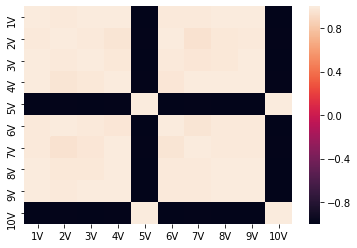

In [36]:
sns.heatmap(new_features_corr)

新特征之间的相关性很高, 都在0.95以上

In [37]:
alphas = [1e-4, 5e-4, 0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 1]
for alpha in alphas:
    metrics, fi = Preds(x_train_0, y_train, x_test_0, y_test, alpha)
    print('\n{}'.format(alpha))
    print(metrics)

# 验证集上 0.001最优
metrics, fi = Preds(x_train_0, y_train, x_test_0, y_test, 0.001)



0.0001
      fold      train      valid       test
0        0  13.369107  10.941365  20.916616
1        1  10.254286  20.316394  20.779509
2        2  11.705515  15.437983  19.312710
3        3  13.117187  11.309768  20.055182
4  overall  12.111524  14.507748  20.266004

0.0005
      fold      train      valid       test
0        0  13.572276  10.473539  20.043746
1        1  10.385401  20.016539  20.069536
2        2  11.841651  15.470250  18.757274
3        3  13.318386  10.846893  19.194573
4  overall  12.279429  14.207699  19.516282

0.001
      fold      train      valid       test
0        0  13.716057  10.333758  19.684615
1        1  10.478943  20.041603  19.755139
2        2  11.933584  15.526028  18.513257
3        3  13.495823  10.733577  18.809445
4  overall  12.406102  14.164555  19.190614

0.005
      fold      train      valid       test
0        0  14.120487  10.204860  19.145468
1        1  10.744437  20.253210  19.232593
2        2  12.240138  15.569626  18.023272
3 

In [38]:
fi

,mean
feature,
RM,85.282010
5V,81.978486
2V,39.592184
3V,9.525817
CHAS,3.186801
RAD,3.020320
1V,1.601744
B,0.824018
ZN,0.090928
